# Hydraulic Systems Monitoring by Stacking RandomForest
- Stephen Duckers
- Data Project Club - May 2023
- __[Stephen's linkedin ](https://www.linkedin.com/in/stephen-jake-duckers/)__
- __[UCI 
Condition monitoring of hydraulic systems Data Set  ](https://archive.ics.uci.edu/ml/datasets/condition+monitoring+of+hydraulic+systems)__ 

## <u>Business Problem Outline:</u><br>
> The objective of this project is to predict the stability of a hydraulic system and what caused the process to degrade. The components of the hydraulic system - `cooler_condition`, `valve_condition`, `internal_pump_leakage` and `hydraulic_accumulator` are based on multi-class classification problem and the stability of the hydraulic system is based on binary classification problem <br>

## <u>Business Problem Approach:</u><br>
> Develop a randomforestclassifier for each degradation state. Then combine these predictions with the sensor data to predict  the stability of the hydraulic system <br>  
 `metric` - recall_weighted (priortize False Negatives - the system is stable but really it is not)
>   - Using "weighted" averaging effectively gives higher importance to the minority classes, which can provide a more balanced evaluation of a model's performance in the presence of class imbalance.

## <u>Business Insights and Recommendations:</u>

> `Valve Condition`: The valve_condition is the most significant factor affecting the stability of the hydraulic system. When the valve_condition is operating at 100%, the system is most stable. EnergyMobil should therefore focus on maintaining optimal valve conditions. <br>__Regular inspections and maintenance of the valves could prevent potential system instabilities__.

> `System Efficiency Sensor (SE)`: The system efficiency sensor (SE) is the second greatest indicator of system stability. EnergyMobil should leverage this sensor's data to predict potential system failures or instabilities. <br> __An alert system could be put in place to notify the team when the sensor's readings drop below a certain threshold, indicating a potential decrease in stability__.

> `Internal Pump Leakage`: Internal_pump_leakage significantly affects the system stability. The system's stability begins to decrease when leakage starts to occur. Hence, it's crucial to monitor and mitigate any internal pump leakages promptly to ensure system stability.

> `Cooler Condition`: The cooler_condition is not a significant factor in determining the system's stability. __This can help EnergyMobil to prioritize its maintenance tasks and focus more on the valve condition and internal pump leakages__.

> __EnergyMobil needs to focus on monitoring valve condition and Internal pump leakage beacause once these processes drop below optimal values the system is more likely to be unstable__

## <u>EDA:</u><br>
   - histogram to check the distribution of data (independent variables)
   - boxplots to check for outliers 
   - line graphs for degradation states over time
   - pairplot to show the relationship between sensor data 
   - countplots for class distributions
   - correalation matrix to compare sensor and degradation states correlation 
   - feature importance on all degradation states and features to find important sensors using randomforestclassifier
   - spearman rank test for feature importance with stable flag and sensor data (does not assume linear relationship or normally distributed data)
   - chi-squared test to see importance of conditions with stable flag
   
## <u>ML:</u><br>
   - QuantileTransformer performs a non-linear transformation based on the ranks of the data, preserving the order of values but potentially redistributing outliers in the transformed space (Want to keep outliers for failed system detection).
   - use SMOTE to handle class imbalance for degradation states (except cooler_condition) and stable_flag
   - One hot encoder degradation states for evaluating the final model

## <u>Improvements:</u><br>
- Use select best features to improve performance and maintain interpretability 
- Hyperparameter tuning - incorporate more hyperparameter tuning since valve_condition recall score decreased by 10% when tuned. this means the model is overfitting
- Use OrdinalEncoder for the degradation conditions instead of Onehotencoder since there is an order to the classes
- Use timeseriessplit - can not use it becasue of the nature of the degradation conditions (specifically cooler_condition) when split with different methods of timeseriessplit, folds only end up with one class or end up with very low recall scores.
- Dimensionality reduction to reduce multicollinearity between sensor data. A PCA did not seperate the stable_flag conditions so it was not used for model training. In the future I want to try T-SNE and UMAP methods to see if local structures and nonlinear patterns can be better captured.

In [30]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import dataframe_image as dfi
import numpy as np
import seaborn as sns
from scipy.stats import spearmanr

# sklearn libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder, QuantileTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.feature_selection import chi2

# imbalanced-learn library
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# joblib for model persistence
from joblib import dump, load

# Pandas display options
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

# matplotlib style options
mpl.style.use('dark_background')
mpl.rcParams.update({'text.color':'white', 'axes.grid': False})
plt.style.use('dark_background')
plt.rcParams.update({'text.color':'white'})

#filter warnings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Using Avery Data

In [31]:
df2 = pd.read_csv('HourlyData.csv')
profile_df = pd.read_csv('profile.txt', sep="\t", header=None)
profile_df.columns = ['cooler_condition', 'valve_condition', 'internal_pump_leakage', 'hydraulic_accumulator', 'stable_flag']
df2 = df2.drop(columns=["Unnamed: 0", "Time"])
df2 = df2.rename(columns={
    "Cooling efficiency": "CE",
    "Cooling power": "CP",
    "Motor power W": "EPS1",
    "Volume flow l/min 1": "FS1",
    "Volume flow l/min 2": "FS2",
    "Pressure bar 1": "PS1",
    "Pressure bar 2": "PS2",
    "Pressure bar 3": "PS3",
    "Pressure bar 4": "PS4",
    "Pressure bar 5": "PS5",
    "Pressure bar 6": "PS6",
    "Efficiency factor": "SE",
    "Temperature 1": "TS1",
    "Temperature  2": "TS2",
    "Temperature  3": "TS3",
    "Temperature  4": "TS4",
    " Vibration mm/s": "VS1"
})

avery_df = pd.concat([df2,profile_df], axis=1)


In [32]:
styled_df = avery_df.head(5).iloc[:, :].style.set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#424242'), ('color', '#f0f0f0')]},
    {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#424242'), ('color', '#f0f0f0')]},
    {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#303030'), ('color', '#f0f0f0')]}
]).hide_index()

dfi.export(styled_df, 'images/df_styled.png')

160301 bytes written to file /var/folders/hn/f_28jr5j09b4_cxwrf6tljjm0000gn/T/tmpigankm3e/temp.png
196125 bytes written to file /var/folders/hn/f_28jr5j09b4_cxwrf6tljjm0000gn/T/tmp9_hdk7po/temp.png
192108 bytes written to file /var/folders/hn/f_28jr5j09b4_cxwrf6tljjm0000gn/T/tmp7xcdubvj/temp.png


# EDA


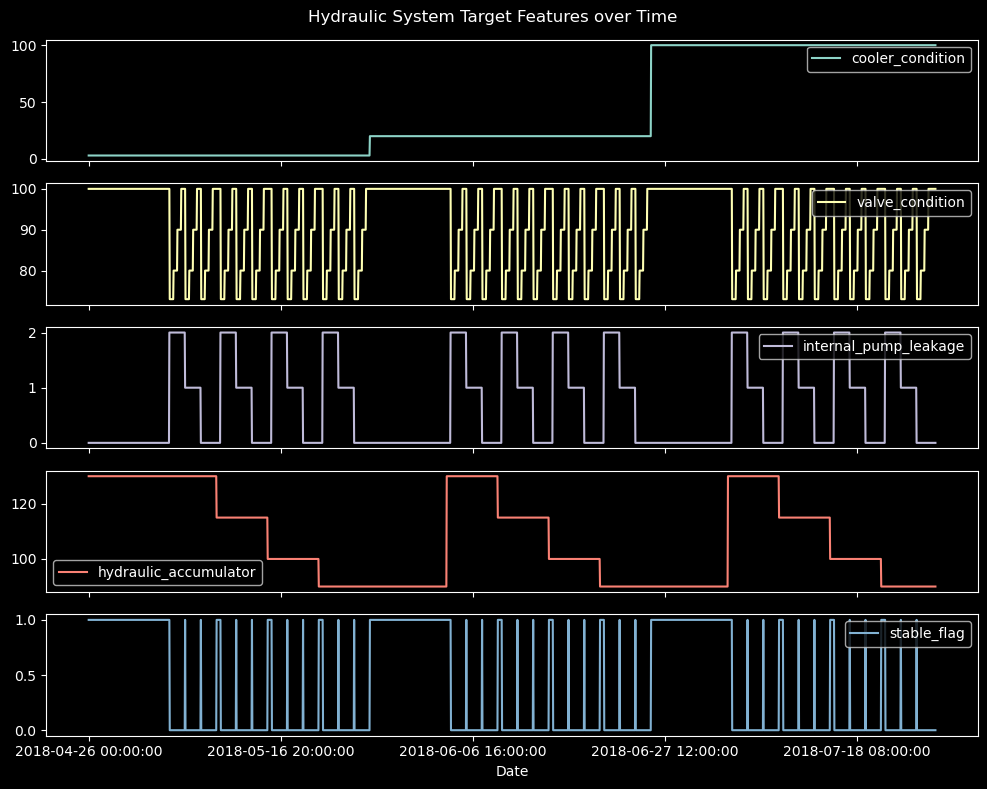

In [33]:
avery_df.plot(x='Date',
              title = "Hydraulic System Target Features over Time",
              y=['cooler_condition', 'valve_condition', 'internal_pump_leakage', 'hydraulic_accumulator', 'stable_flag'],
              figsize=(10,8),
              subplots=True)
plt.tight_layout()
plt.savefig('images/target_features.png', format='png')
plt.show()




# Sensor Data Histograms

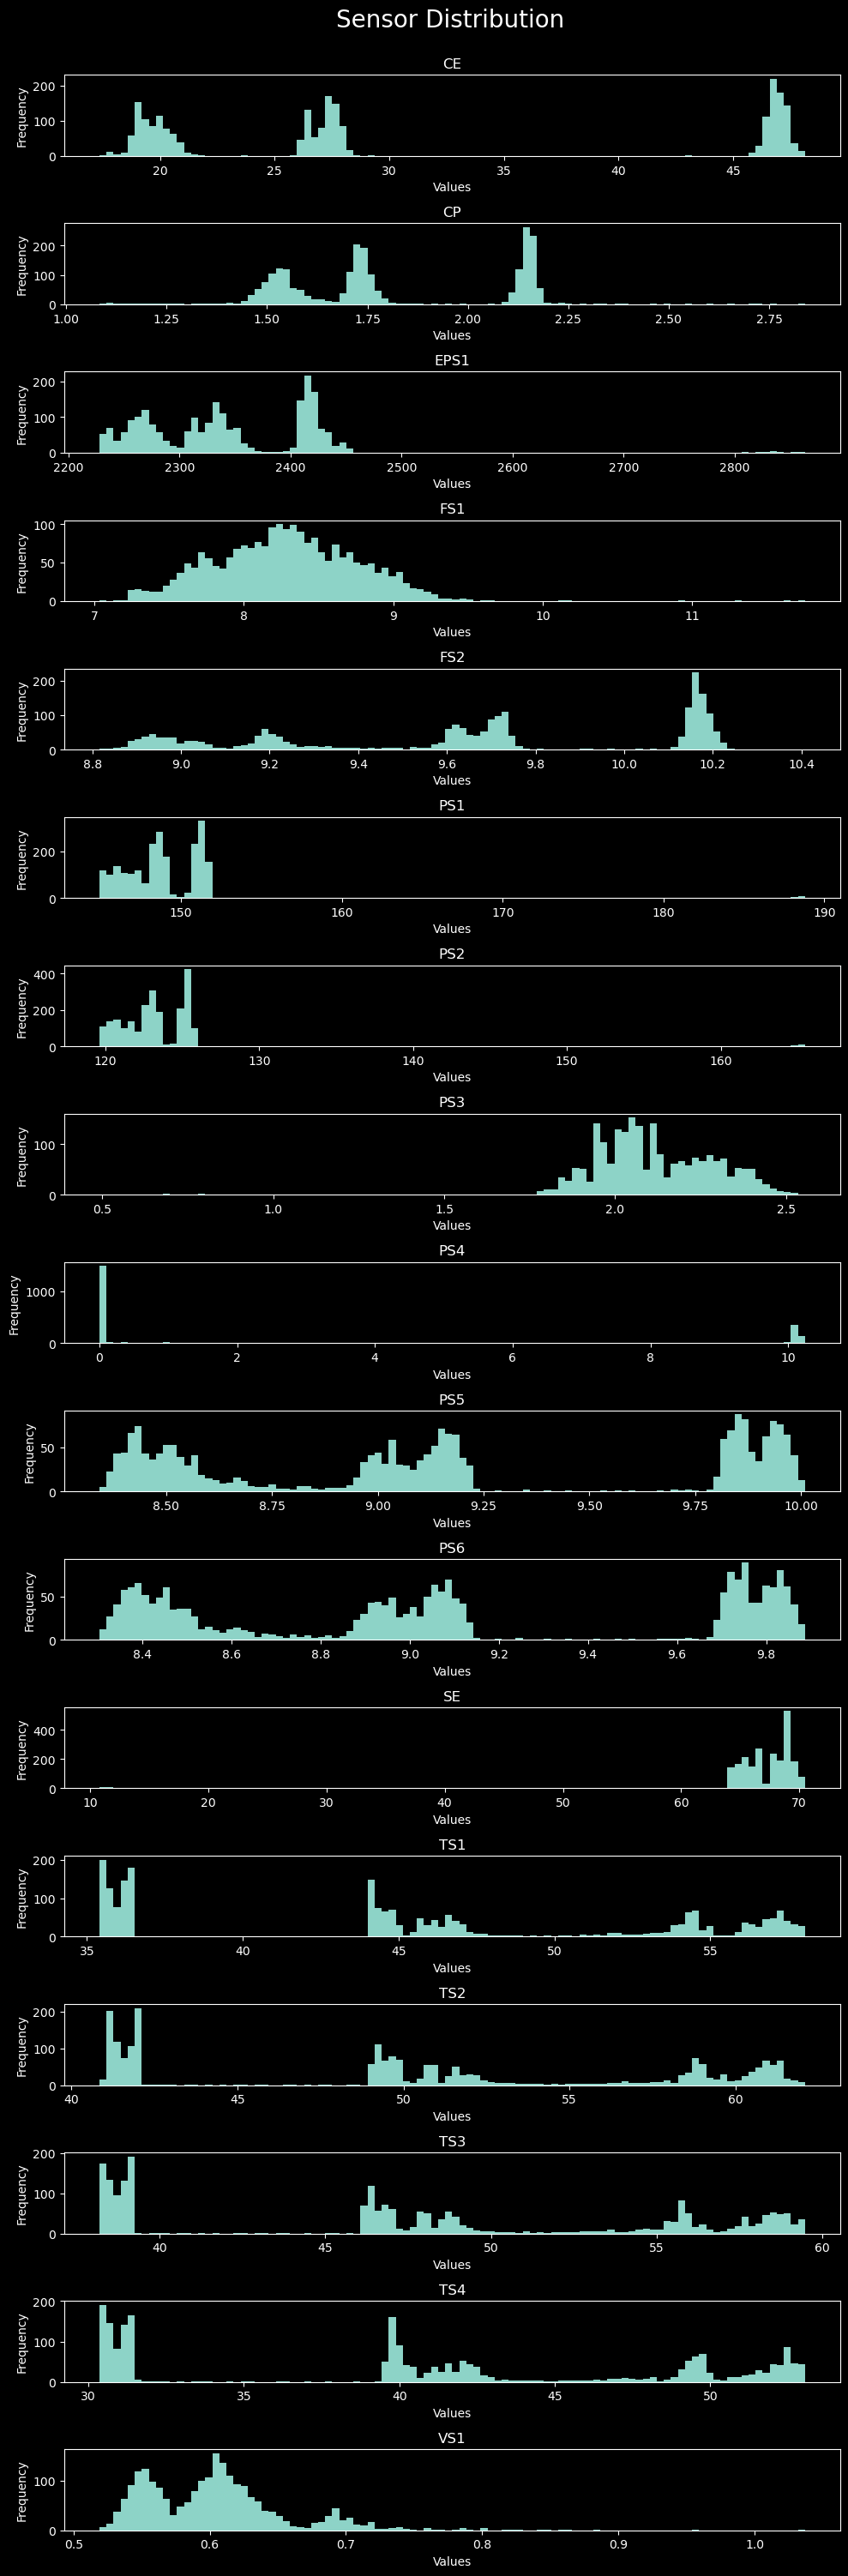

In [34]:
# Define the list of sensor columns
sensor_columns = ['CE', 'CP', 'EPS1', 'FS1', 'FS2', 'PS1', 'PS2', 'PS3', 'PS4', 'PS5',
                  'PS6', 'SE', 'TS1', 'TS2', 'TS3', 'TS4', 'VS1']

# Create subplots for each sensor
fig, axes = plt.subplots(nrows=len(sensor_columns), figsize=(10, 30))

# Set the title for the whole figure
fig.suptitle('Sensor Distribution', fontsize=20, x=.53, y=1)

# Iterate over each sensor column and plot histogram
for i, column in enumerate(sensor_columns):
    ax = axes[i]
    ax.hist(avery_df[column], bins=100)
    ax.set_title(column)
    ax.set_xlabel('Values')
    ax.set_ylabel('Frequency')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


# Sensor Data Boxplots

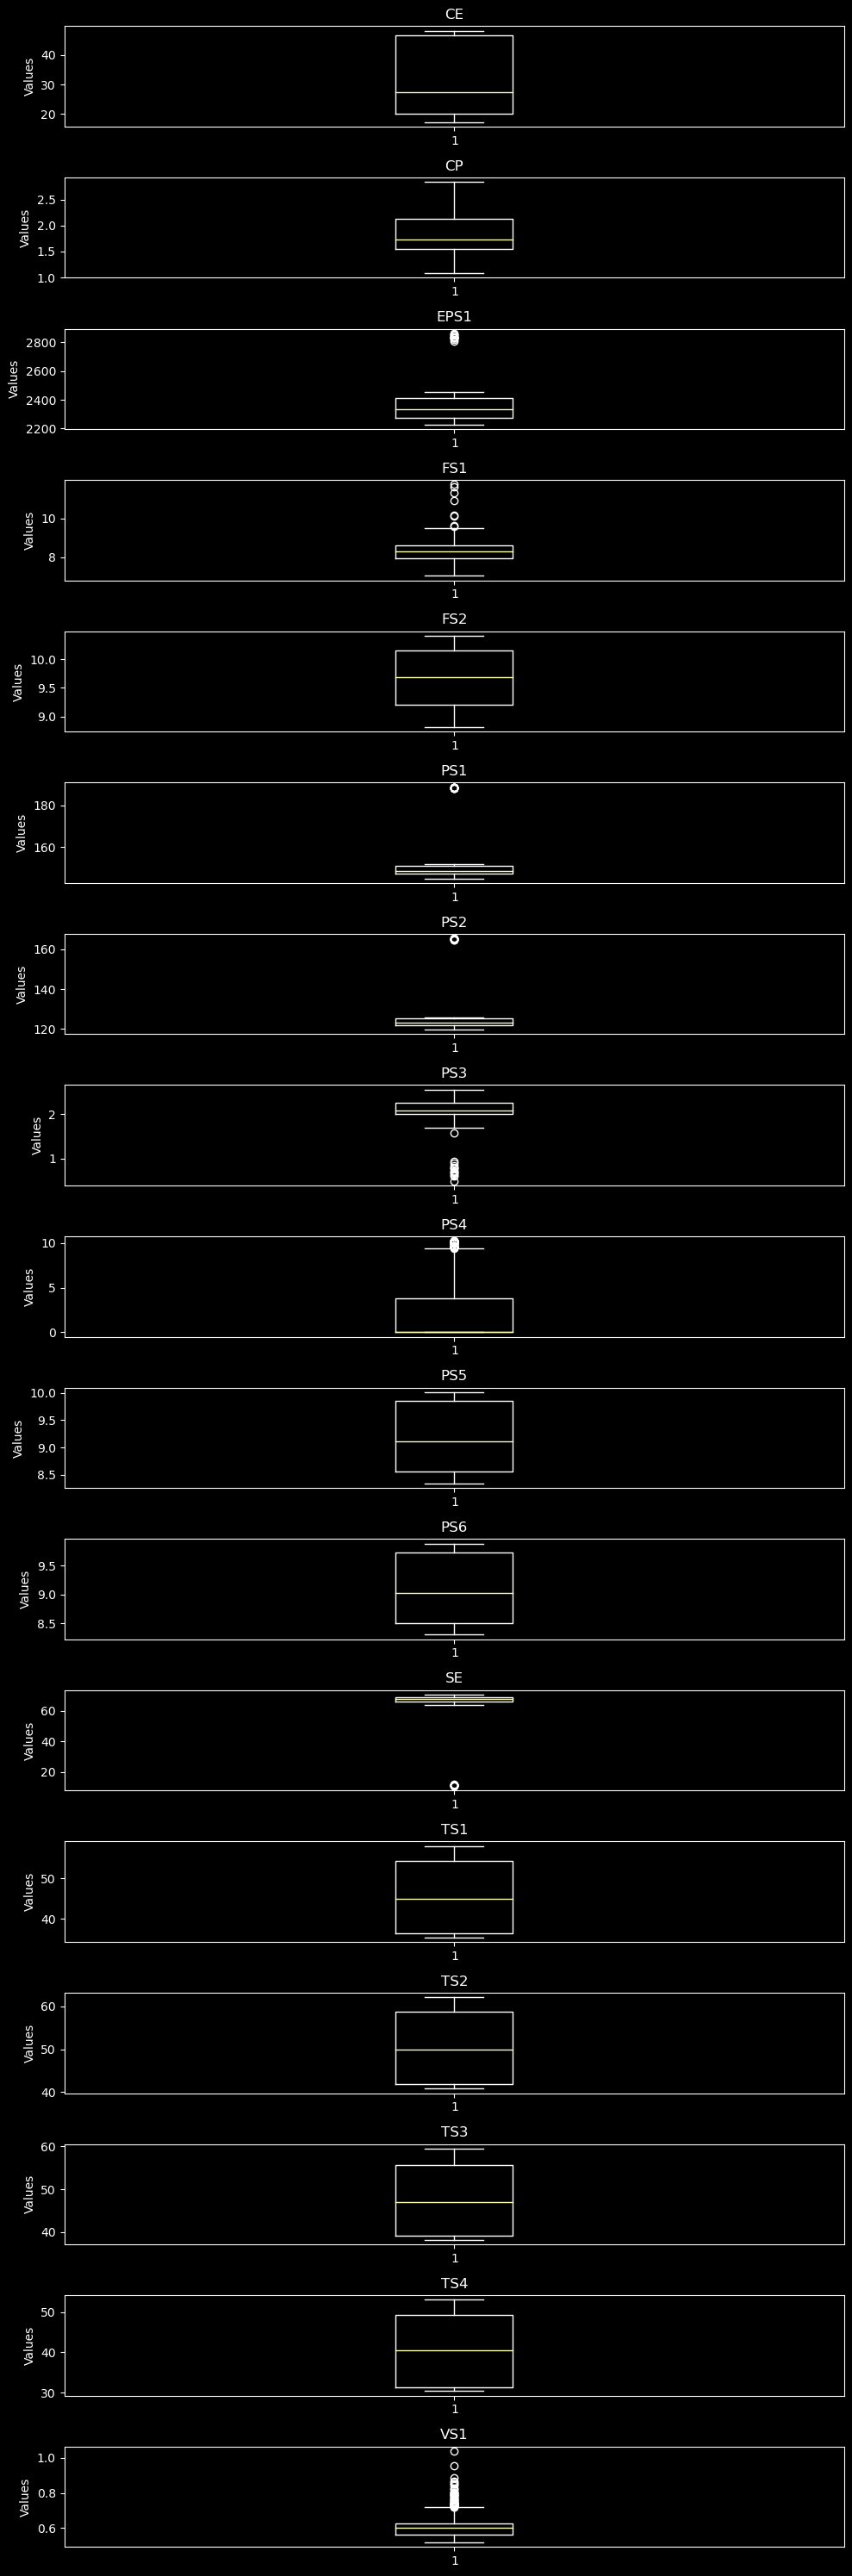

In [35]:
# Define the list of sensor columns
sensor_columns = ['CE', 'CP', 'EPS1', 'FS1', 'FS2', 'PS1', 'PS2', 'PS3', 'PS4', 'PS5',
                  'PS6', 'SE', 'TS1', 'TS2', 'TS3', 'TS4', 'VS1']

# Create subplots for each sensor
fig, axes = plt.subplots(nrows=len(sensor_columns), figsize=(10, 30))

# Iterate over each sensor column and plot box plot
for i, column in enumerate(sensor_columns):
    ax = axes[i]
    ax.boxplot(avery_df[column])
    ax.set_title(column)
    ax.set_ylabel('Values')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


# Pairplot of Sensor Data

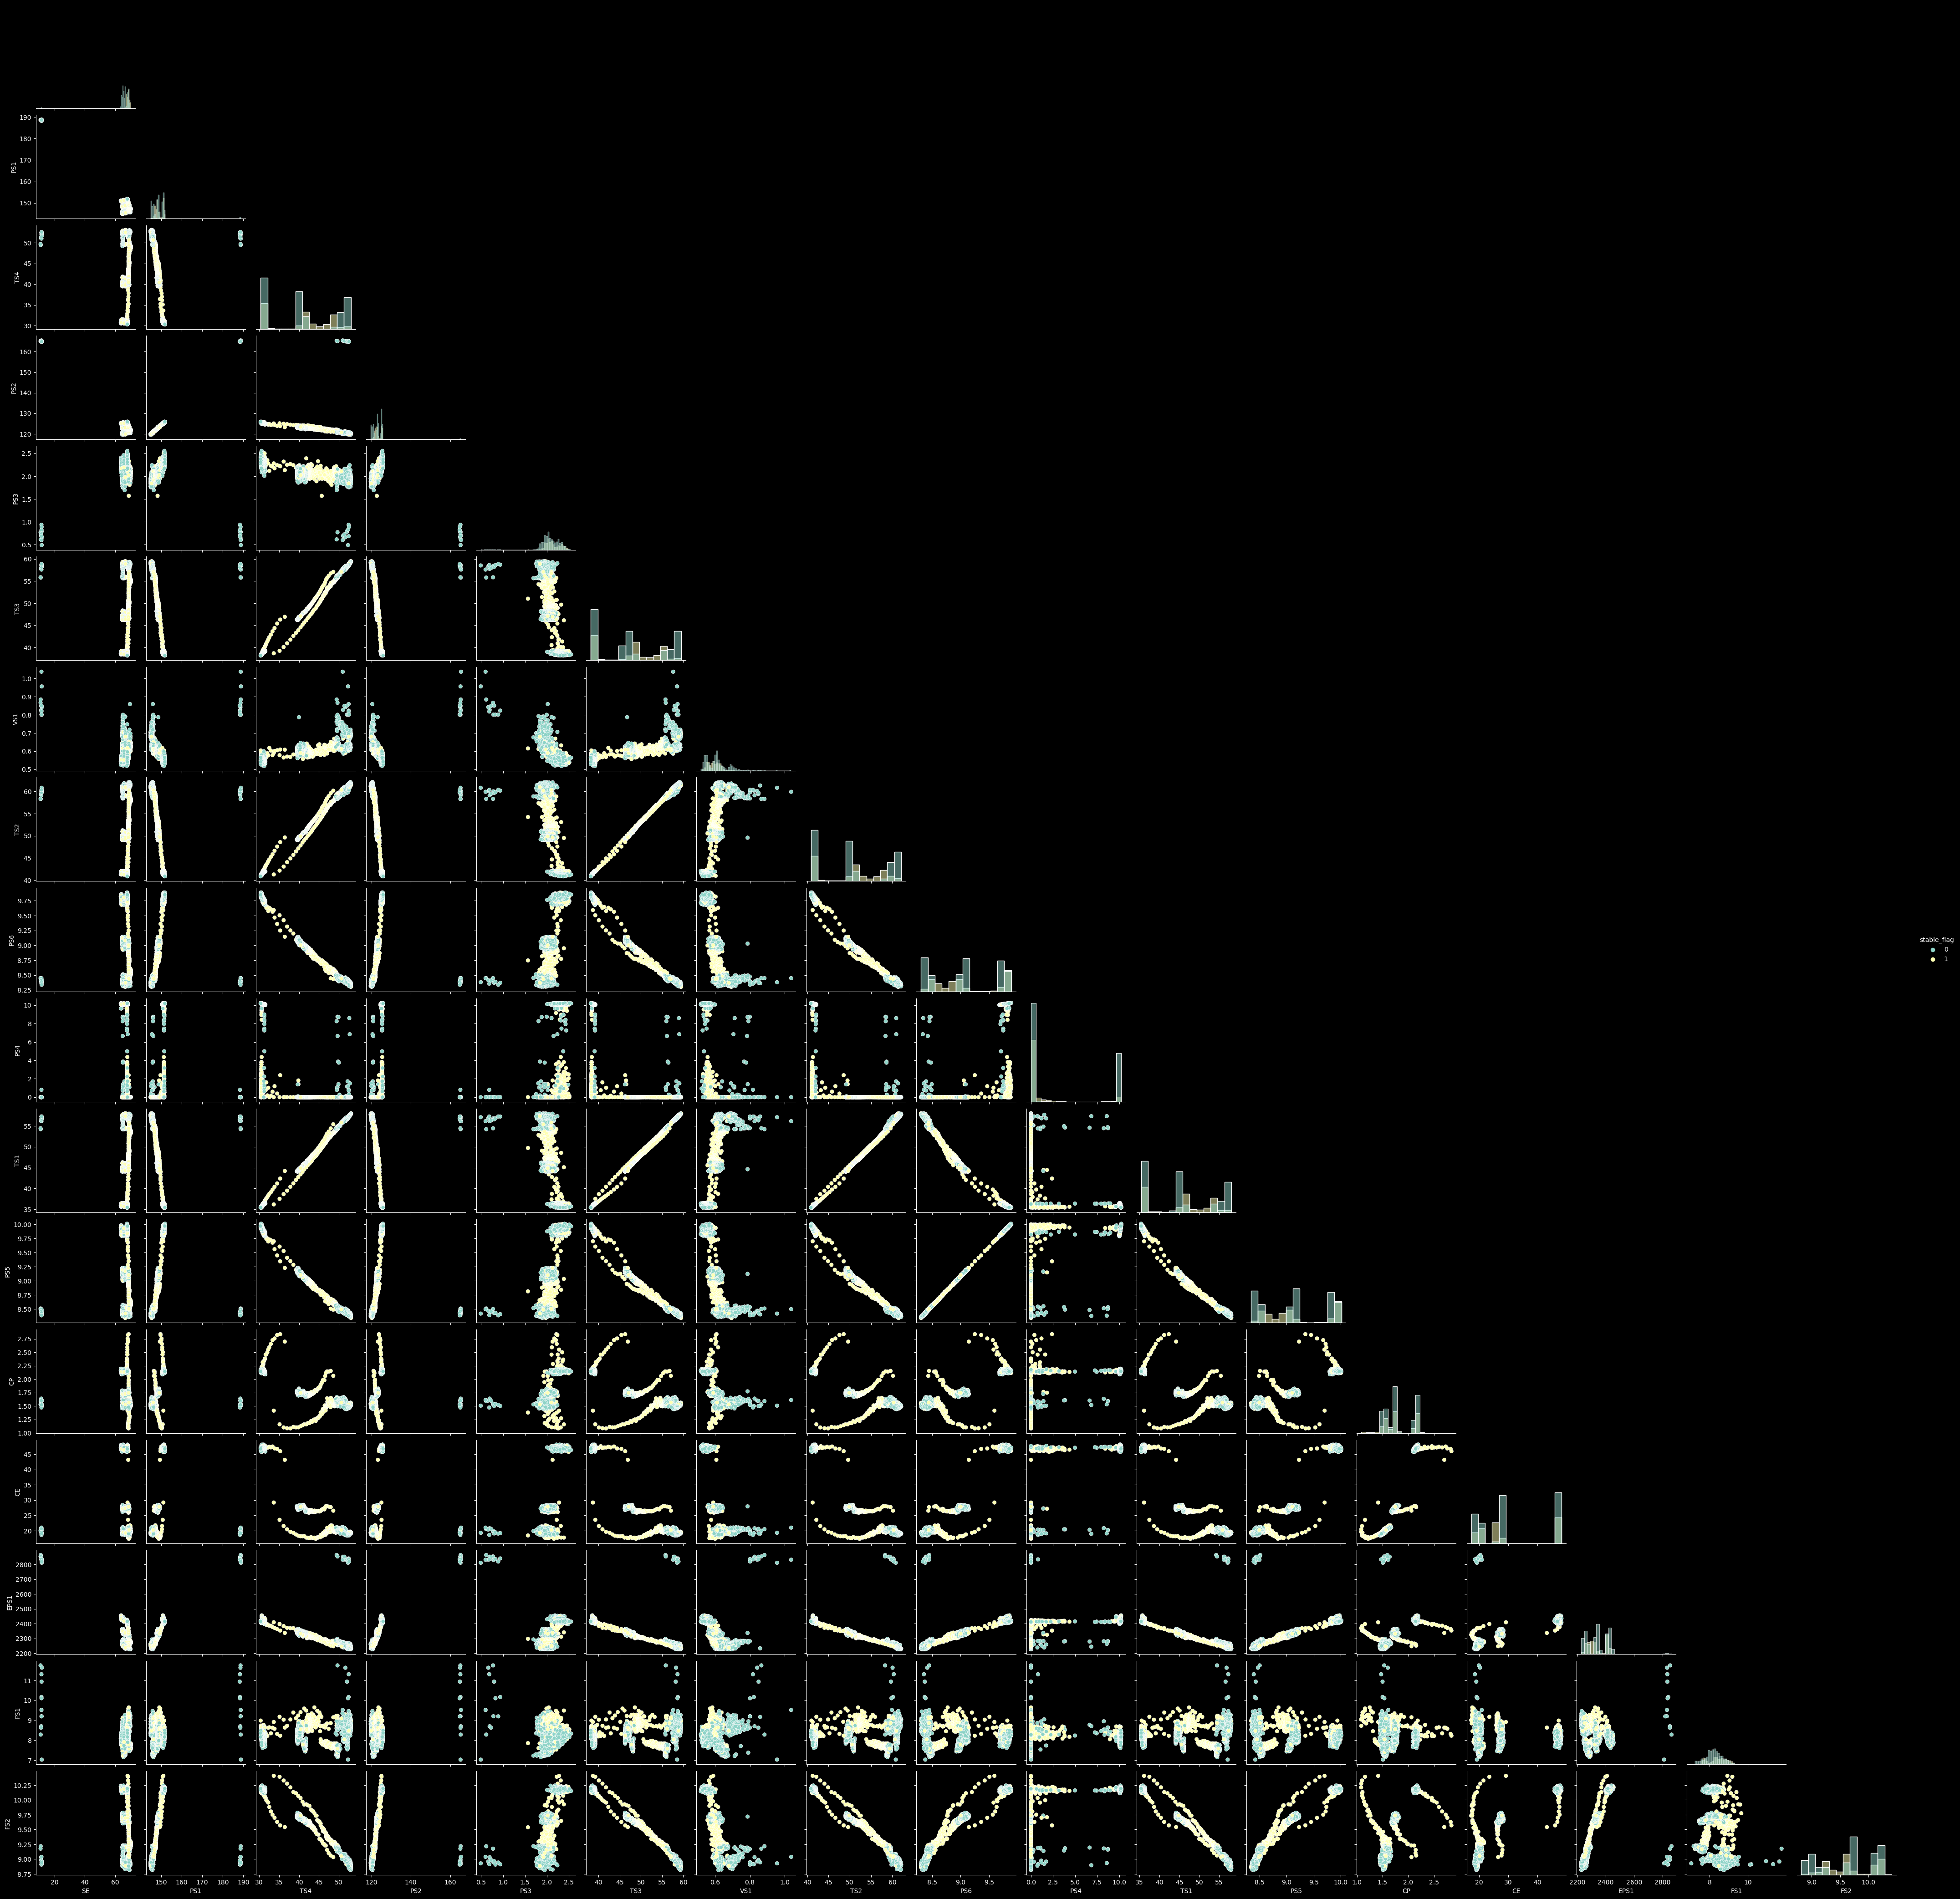

In [36]:
# Subset the columns for the pairplot
columns = ['SE', 'PS1', 'TS4', 'PS2', 'PS3', 'TS3', 'VS1', 'TS2', 'PS6', 
           'PS4', 'TS1', 'PS5', 'CP', 'CE', 'EPS1', 'FS1', 'FS2', 'stable_flag'
          ]

# Create the pairplot
sns.pairplot(avery_df[columns], diag_kind='hist', hue = "stable_flag", corner=True)

# Show the plot
plt.show()

# Class Distribution

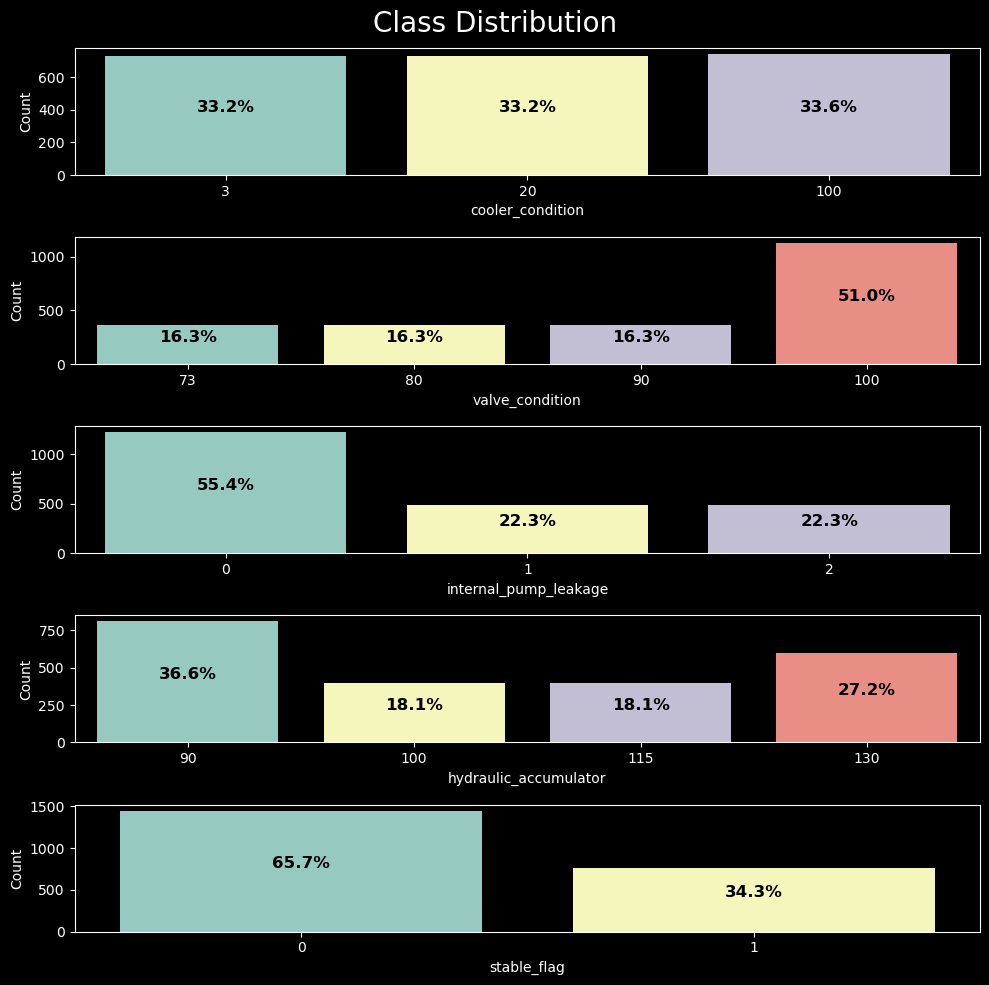

In [37]:
# Subset the columns
columns = ['cooler_condition','valve_condition', 'internal_pump_leakage', 'hydraulic_accumulator', 'stable_flag']

# Create subplots
fig, axes = plt.subplots(len(columns), 1, figsize=(10, 10))

# Set the title for the whole figure
fig.suptitle('Class Distribution', fontsize=20)

# Iterate over columns and plot count plots
for i, column in enumerate(columns):
    ax = axes[i]
    sns.countplot(x=column, data=avery_df, ax=ax)
    ax.set_xlabel(column)
    ax.set_ylabel('Count')

    # Calculate total count of records for the current column
    total = len(avery_df[column])

    # Iterate over all bars and add percentage text inside each bar
    for p in ax.patches:
        height = p.get_height()
        # If height is 0, we want to avoid division by zero error
        if height == 0:
            continue
        percentage = f'{100 * height/total:.1f}%'
        ax.text(p.get_x()+p.get_width()/2., height/2, percentage, ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

# Adjust spacing between subplots
plt.tight_layout()

plt.savefig('images/class_distributions.png', format='png')

# Show the plot
plt.show()


## Correlation heatmap

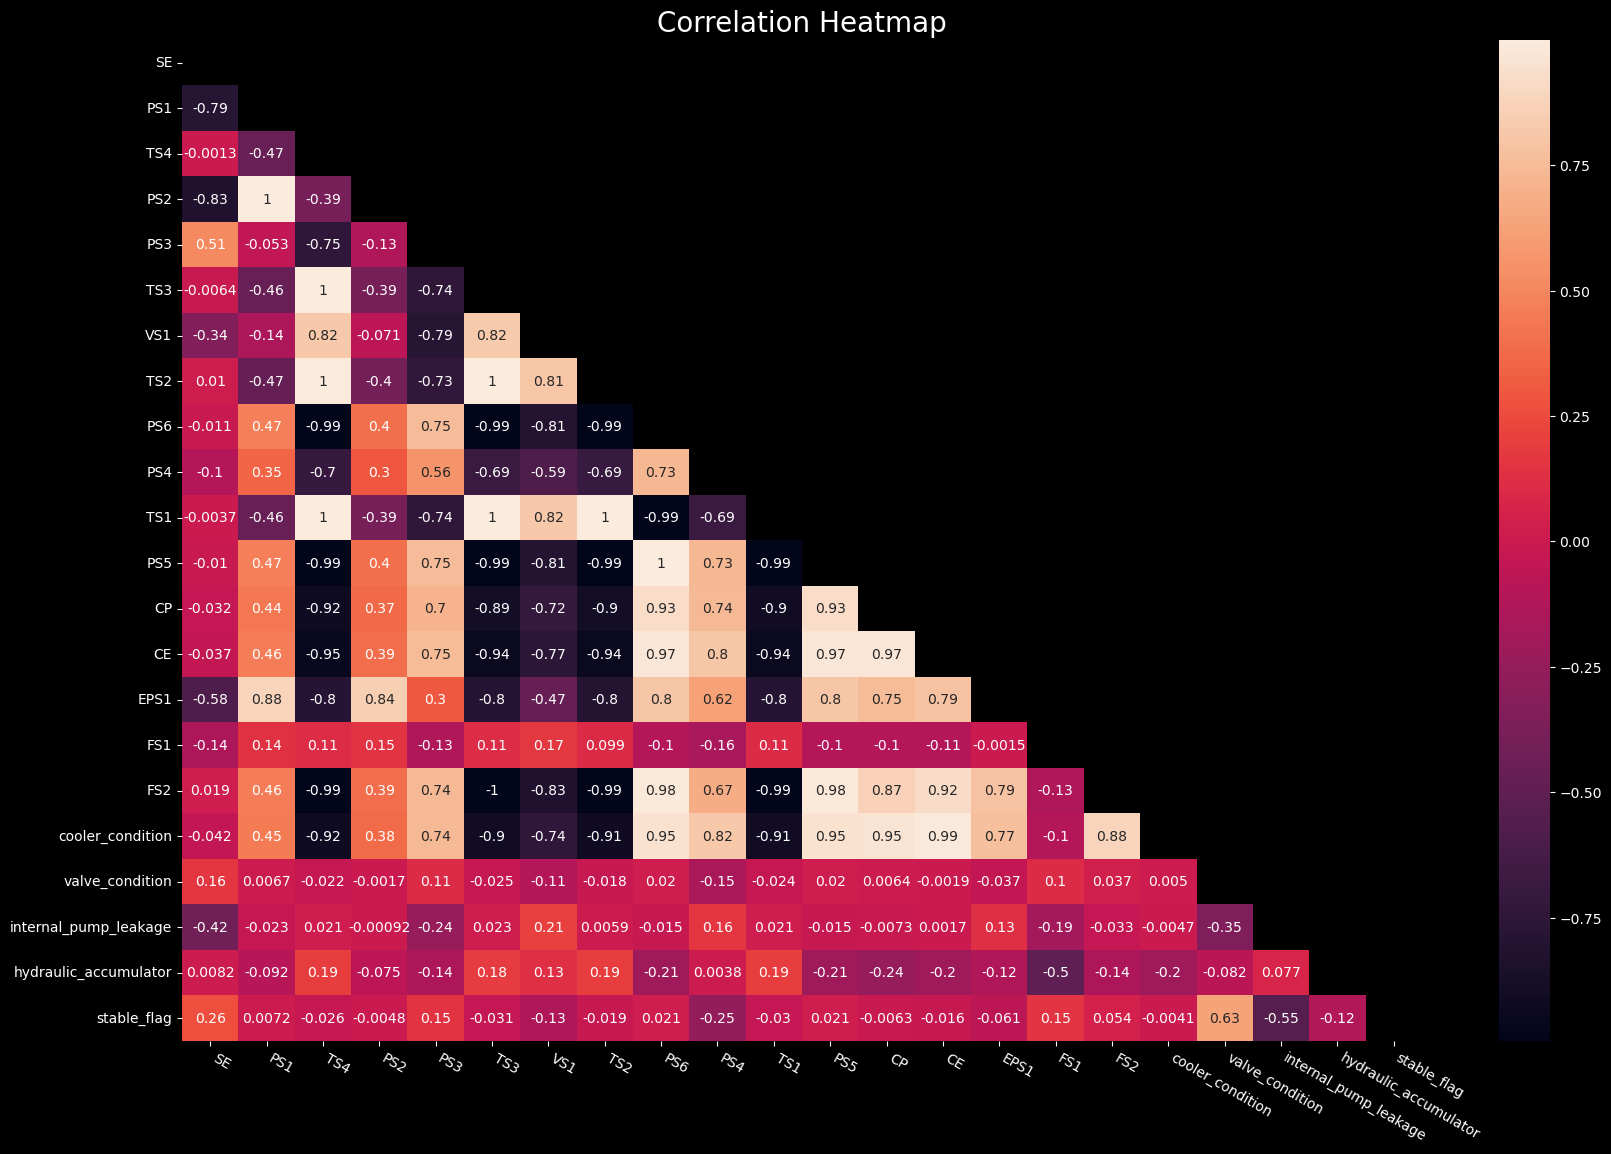

In [38]:
# Select the columns for correlation heatmap
columns = ['SE', 'PS1', 'TS4', 'PS2', 'PS3', 'TS3', 'VS1', 'TS2', 'PS6', 'PS4', 'TS1',
           'PS5', 'CP', 'CE', 'EPS1', 'FS1', 'FS2', 'cooler_condition', 'valve_condition',
           'internal_pump_leakage', 'hydraulic_accumulator', 'stable_flag']

# Create a new figure with a size of 20x13
fig, ax = plt.subplots(figsize=(20, 13))

# Extract the selected columns and compute the correlation matrix
correlation_matrix = avery_df[columns].corr()

# Create a mask to hide the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Plot a heatmap of the correlation matrix with the mask applied
sns.heatmap(correlation_matrix, annot=True, ax=ax, mask=mask)

# Set the title and rotate x-axis labels
ax.set_title('Correlation Heatmap', fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), rotation=-30, ha='left')

plt.savefig('images/correlation_heatmap.png', format='png')
# Show the plot
plt.show()


# Statistical Test: Spearman Rank and Chi-squared
### Spearman Rank Test
- Based on the Spearman's rank correlation tests, we found a few significant correlations between the sensor data and our target variable 'stable_flag'. Notably, the SE sensor showed a strong positive correlation (rho=0.5045, p=0.0), implying that higher values of SE are typically associated with higher stability.

- The FS1 and PS3 sensors also displayed a significant positive correlation with 'stable_flag', albeit weaker than SE (rho=0.1656, p=0.0 for FS1 and rho=0.1488, p=0.0 for PS3).

- On the other hand, the PS4 sensor showed a weak negative correlation with 'stable_flag' (rho=-0.1348, p=0.0), meaning that higher readings in PS4 are usually associated with lower stability.

- Features like "FS2" and "CP" show weak correlations with the target variable, as their rho values are close to zero and their p-values are above the commonly used significance level of 0.05. This suggests their correlations with the target variable may not be statistically significant.

### Chi-squared Test
- the valve_condition, internal_pump_leakage, and hydraulic_accumulator features have strong associations with the stable_flag target variable, as indicated by their statistically significant p-values of 0.0.

- The valve_condition feature yielded a Chi-square score of 1098.5544, internal_pump_leakage had a score of 664.4189, and the hydraulic_accumulator feature scored 81.0694. The high Chi-square scores suggest a strong dependency between these features and the stable_flag target variable.

- The cooler_condition feature, however, did not show a statistically significant association with stable_flag, with a p-value of 0.2034, indicating that the variability in stable_flag cannot be explained by the cooler_condition.

- the degradation states (valve_condition, internal_pump_leakage, and hydraulic_accumulator) have significant associations with the stable_flag target variable and are likely important features for our predictive model. The cooler_condition feature might not be as influential, given its high p-value.


In [39]:
features = avery_df.drop(columns=['Date','cooler_condition', 'valve_condition', 'internal_pump_leakage', 'hydraulic_accumulator', 'stable_flag'])
target = avery_df['stable_flag']

# Define an empty DataFrame to store results
spearman_results = pd.DataFrame(columns=['Feature', 'Spearman rho', 'p-value'])

# Calculate Spearman correlation and p-value for each feature
for column in features.columns:
    rho, p_value = spearmanr(features[column], target)
    rho = round(rho, 4)
    p_value = round(p_value, 4)
    
    # Prepare a DataFrame with current row
    current_result = pd.DataFrame({'Feature': [column], 
                                'Spearman rho': [rho], 
                                'p-value': [p_value]})
    
    # Concat current row to the DataFrame
    spearman_results = pd.concat([spearman_results, current_result], ignore_index=True)

# Sort DataFrame by p-value
spearman_results_sorted = spearman_results.sort_values(by=['p-value','Spearman rho'], ascending=[False,False])

# Get the indices of the top two rows in terms of p-value
top_two_indices = spearman_results_sorted.iloc[:2].index

# Define a subset including only the top two p-values
slice_ = pd.IndexSlice[top_two_indices, 'p-value']

# Highlight the top two p-values
spearman_results_sorted_styled = spearman_results_sorted.style.set_properties(**{'background-color': 'yellow', 'color': 'black'}, subset=slice_).set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#424242'), ('color', '#f0f0f0')]},
        {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#424242'), ('color', '#f0f0f0')]},
        {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#303030'), ('color', '#f0f0f0')]}
    ]).hide(axis="index")

# Save DataFrame to png
dfi.export(spearman_results_sorted_styled, 'images/spearman_results.png')

spearman_results_sorted_styled


140748 bytes written to file /var/folders/hn/f_28jr5j09b4_cxwrf6tljjm0000gn/T/tmpa2q33swf/temp.png


In [40]:
features = avery_df[['cooler_condition', 'valve_condition', 'internal_pump_leakage', 'hydraulic_accumulator']]
target = avery_df['stable_flag']

chi_scores = chi2(features, target)

# Define an empty DataFrame to store results
chi_square_results = pd.DataFrame(columns=['Feature', 'Chi-square score', 'p-value'])

# chi_scores[0] contains the chi-square scores and chi_scores[1] contains the p-values
for i in range(len(features.columns)):
    chi_score = round(chi_scores[0][i], 4)
    p_value = round(chi_scores[1][i], 4)
    
    # Prepare a DataFrame with current row
    current_result = pd.DataFrame({'Feature': [features.columns[i]], 
                                   'Chi-square score': [chi_score], 
                                   'p-value': [p_value]})
    
    # Concat current row to the DataFrame
    chi_square_results = pd.concat([chi_square_results, current_result], ignore_index=True)
                                                      
# Sort DataFrame by p-value and apply the styling
chi_square_results_sorted = chi_square_results.sort_values(by=['p-value', 'Chi-square score'], ascending=[False,False])

# Highlight the first p-value cell
slice_ = pd.IndexSlice[chi_square_results_sorted.index[0], 'p-value']
chi_square_results_sorted_styled = chi_square_results_sorted.style.set_properties(**{'background-color': 'yellow', 'color': 'black'}, subset=slice_).set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#424242'), ('color', '#f0f0f0')]},
        {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#424242'), ('color', '#f0f0f0')]},
        {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#303030'), ('color', '#f0f0f0')]}
    ]).hide(axis="index")

# Save DataFrame to pdf
dfi.export(chi_square_results_sorted_styled, 'images/chisquare_results.png')

chi_square_results_sorted_styled


75801 bytes written to file /var/folders/hn/f_28jr5j09b4_cxwrf6tljjm0000gn/T/tmp5b_i80h_/temp.png


# Feature Importance - RandomForestClassifier 

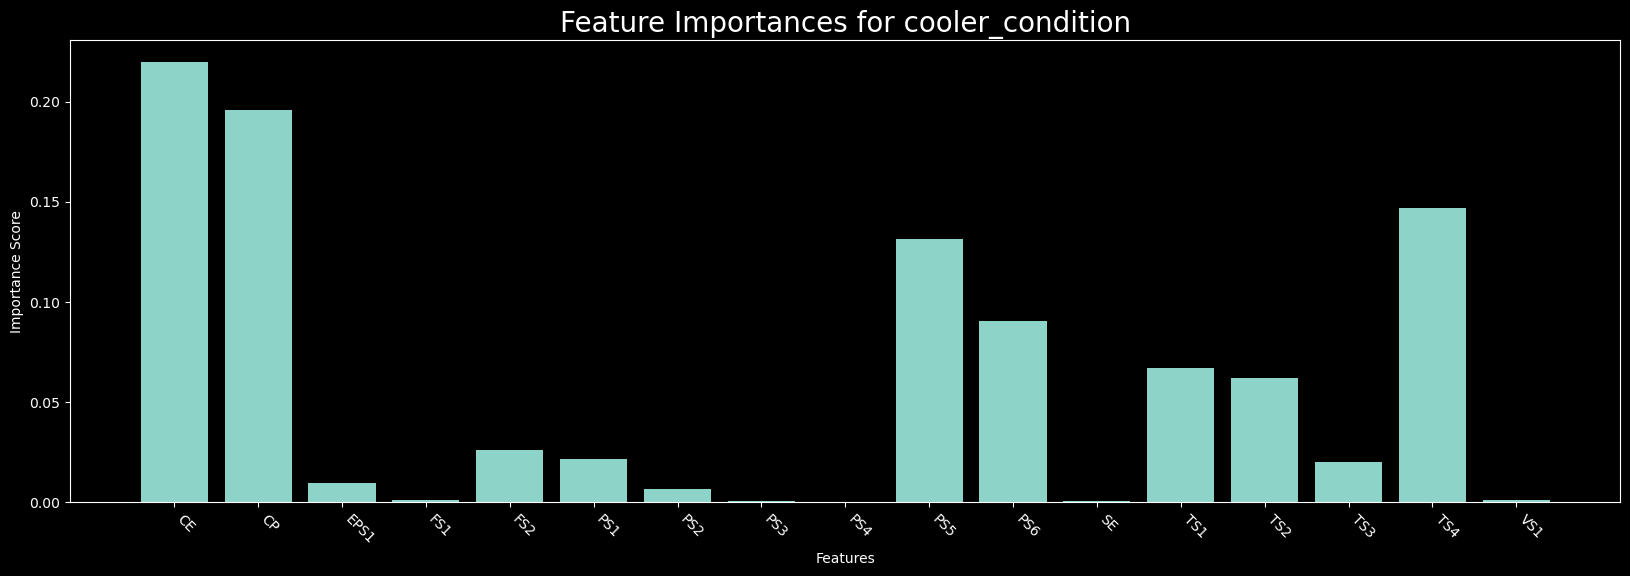

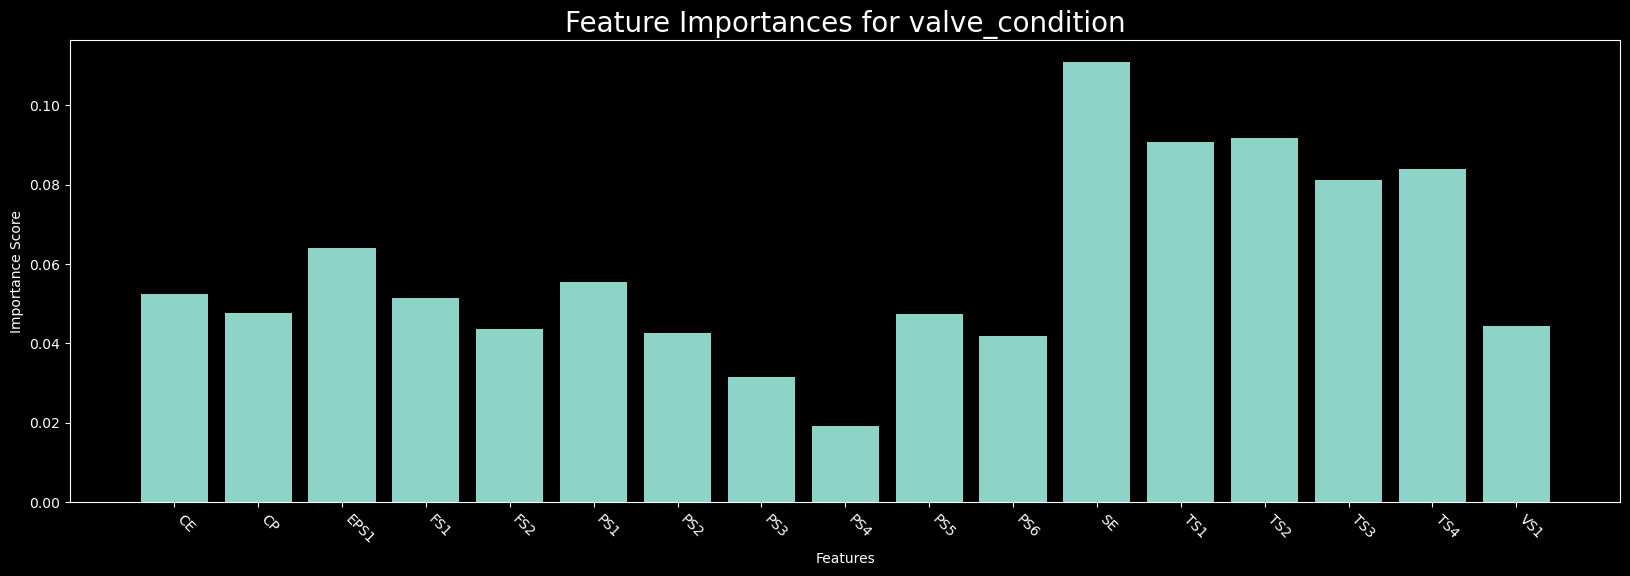

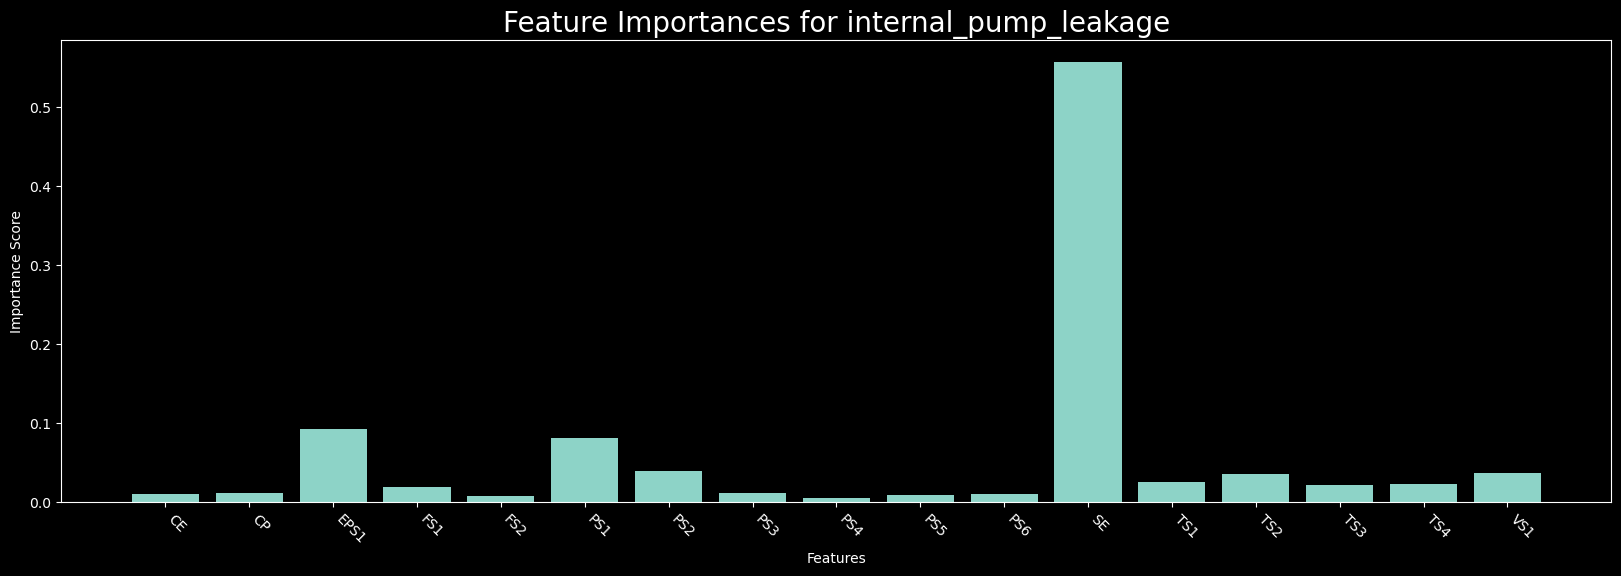

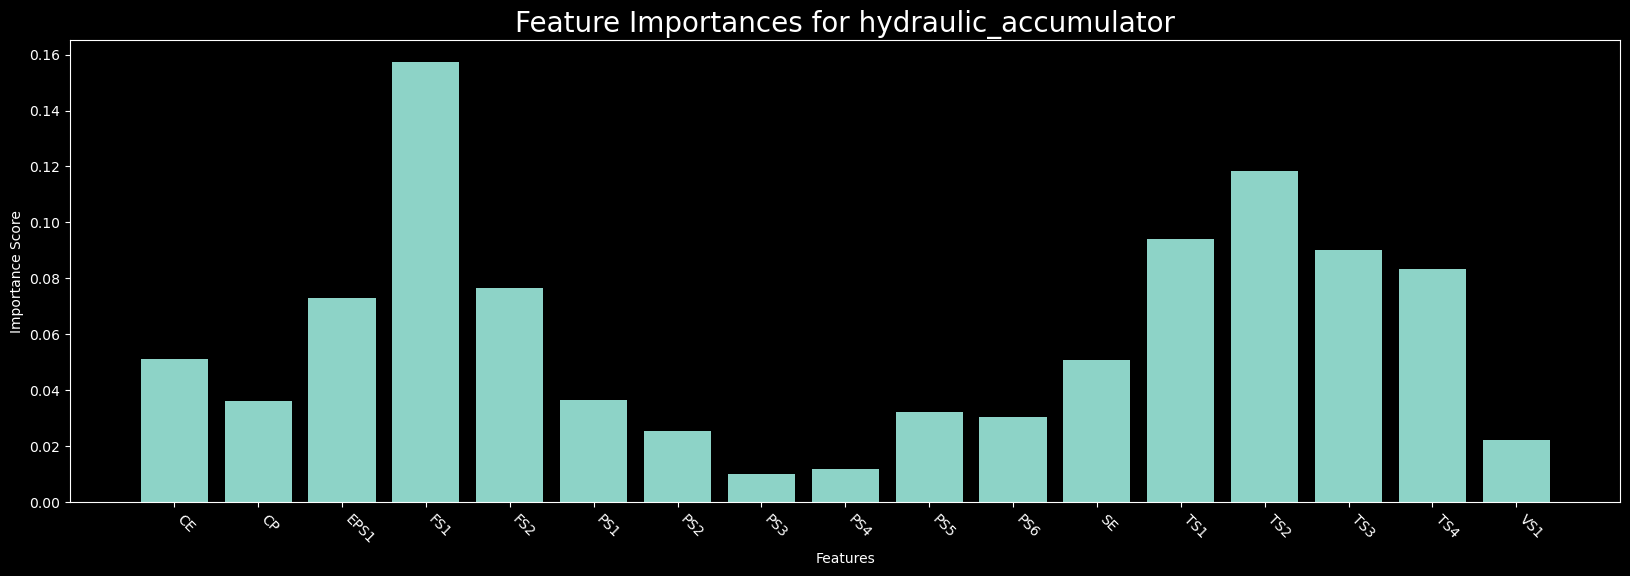

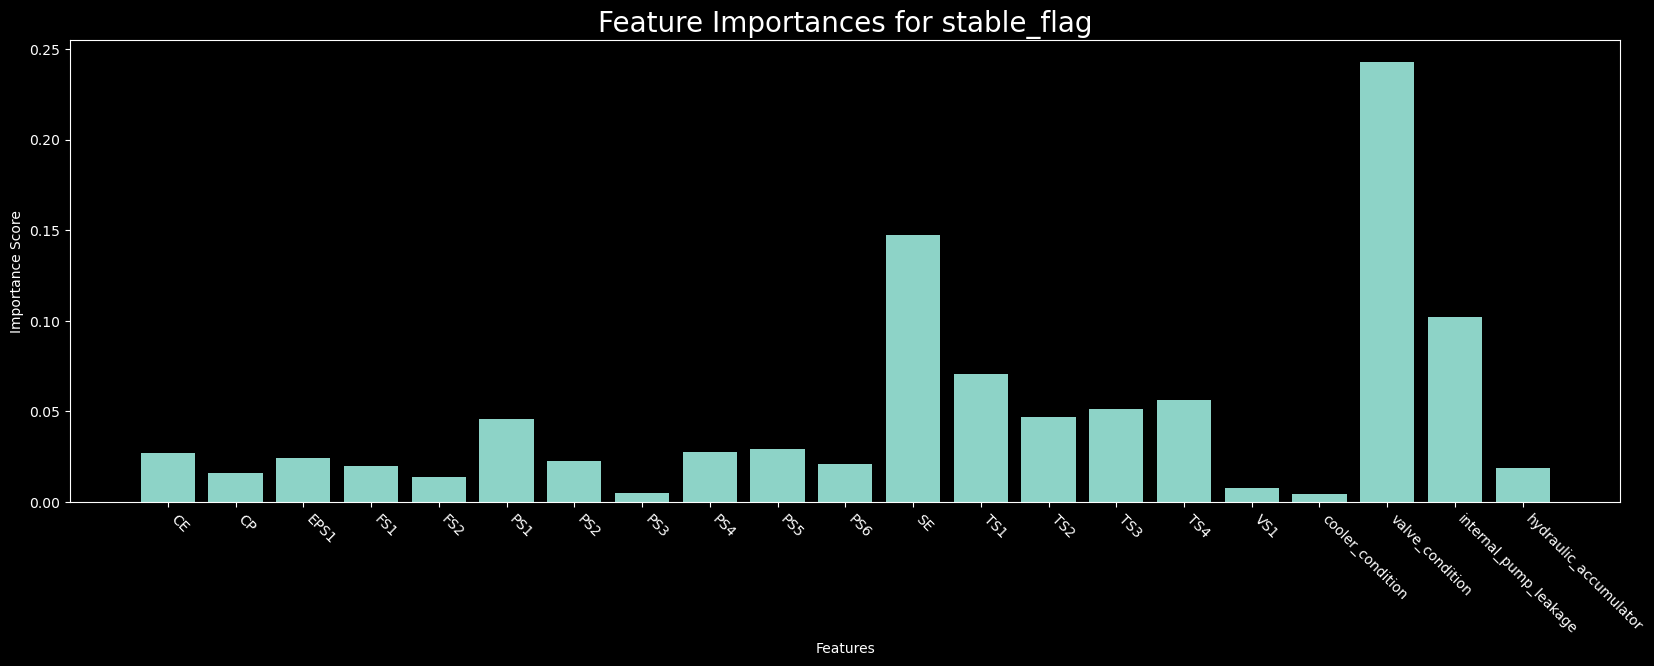

In [41]:
targets = ['cooler_condition', 'valve_condition', 'internal_pump_leakage', 'hydraulic_accumulator', 'stable_flag']

# Loop through each target and create a separate RandomForestClassifier model
for target in targets:

    y = avery_df[target]
   
    if target == "stable_flag":
        X = avery_df.drop(columns=['Date','stable_flag'])
    else:
        X = avery_df.drop(columns=['Date','cooler_condition', 'valve_condition', 'internal_pump_leakage', 'hydraulic_accumulator', 'stable_flag'])
    
    # Create a RandomForestClassifier model
    model = RandomForestClassifier()

    # Train the model
    model.fit(X,y)

    # Get feature importances
    importances = model.feature_importances_

    # Plot feature importances
    fig, ax = plt.subplots(figsize=(20,6))
    ax.bar(X.columns, importances)
    ax.set_xlabel('Features')
    ax.set_ylabel('Importance Score')
    ax.set_title(f"Feature Importances for {target}", fontsize= 20)
    plt.xticks(rotation=-45, ha='left')

    # Save the figure as a png file
    # 'tight' parameter for bbox_inches ensures that the whole area of the figure is saved
    plt.savefig(f"images/{target}_importances.png", bbox_inches='tight')

    plt.show()


# Randomforest Fitting for each Degradation States and Stable Flag

In [42]:
X_full_train, X_test = train_test_split(avery_df, test_size=0.2, random_state=1)
X_train, X_val = train_test_split(X_full_train, test_size=0.25, random_state=1)

In [43]:
# Define a custom styling function
def highlight_cell(value):
    if isinstance(value, str) and value.endswith('weighted avg'):
        return 'background-color: yellow; color: black'
    if isinstance(value, float) and value == classification_rep_df.loc['weighted avg', 'recall']:
        return 'background-color: yellow; color: black'
    return ''

In [44]:
targets = ['cooler_condition', 'valve_condition', 'internal_pump_leakage', 'hydraulic_accumulator']

for target in targets:
    # Prepare the training and validation sets
    X = X_train.drop(columns=['Date', 'cooler_condition', 'valve_condition', 'internal_pump_leakage', 'hydraulic_accumulator', 'stable_flag'])
    y = X_train[target]
    
    X_val_transformed = X_val.drop(columns=['Date', 'cooler_condition', 'valve_condition', 'internal_pump_leakage', 'hydraulic_accumulator', 'stable_flag'])
    y_val = X_val[target]
    
    # Create an instance of SMOTE
    sm = SMOTE(random_state=1)
    
    # Create instances of your selected scaler and classifier
    quant = QuantileTransformer(output_distribution='normal', random_state=1)
    classifier = RandomForestClassifier(random_state=1)  
    
    # Create a pipeline with SMOTE, scaler, and classifier
    pipeline = ImbPipeline([('smote', sm), ('scaler', quant), ('classifier', classifier)])
    
    # Fit the pipeline on the training set
    pipeline.fit(X, y)
    
    # Transform X_val using the scaler
    X_val_transformed = pipeline.named_steps['scaler'].transform(X_val_transformed)
    
    # Use the pipeline to make predictions on the validation set
    y_val_pred = pipeline.named_steps['classifier'].predict(X_val_transformed)
    
    # Compute precision, recall, and F1 score and output as a dictionary
    classification_rep = classification_report(y_val, y_val_pred, output_dict=True)
    
    # Convert the classification report dictionary to a DataFrame
    classification_rep_df = pd.DataFrame(classification_rep).transpose().drop(index=['accuracy', 'macro avg'])

    # Apply the custom styling function
    styled_df = classification_rep_df.style.applymap(highlight_cell).set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#424242'), ('color', '#f0f0f0')]},
        {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#424242'), ('color', '#f0f0f0')]},
        {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#303030'), ('color', '#f0f0f0')]}
    ])
    
    # Save the styled DataFrame as a png image
    dfi.export(styled_df, f'images/{target}_class_rep.png')
    
    # Save the model to a file
    dump(pipeline, f'models/{target}_model.joblib') 
    
    # Display for checking
    print(f"Classification Report: {target}")
    display(styled_df)


Classification Report: cooler_condition


81985 bytes written to file /var/folders/hn/f_28jr5j09b4_cxwrf6tljjm0000gn/T/tmppgivbb0g/temp.png


Classification Report: valve_condition


92124 bytes written to file /var/folders/hn/f_28jr5j09b4_cxwrf6tljjm0000gn/T/tmpkln4usb8/temp.png


Classification Report: internal_pump_leakage


80563 bytes written to file /var/folders/hn/f_28jr5j09b4_cxwrf6tljjm0000gn/T/tmpn_7zsvqv/temp.png


Classification Report: hydraulic_accumulator


92357 bytes written to file /var/folders/hn/f_28jr5j09b4_cxwrf6tljjm0000gn/T/tmpa61amwj_/temp.png


In [45]:
# Define the columns to be one-hot encoded and the columns for the quantile transformer
categorical_features = ['cooler_condition', 'valve_condition', 'internal_pump_leakage', 'hydraulic_accumulator']
quant_features = ['CE', 'CP', 'EPS1', 'FS1', 'FS2', 'PS1', 'PS2', 'PS3', 'PS4', 'PS5','PS6', 'SE', 'TS1', 'TS2', 'TS3', 'TS4', 'VS1']

# Create a preprocessor that applies the OneHotEncoder and the QuantileTransformer to the specified columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', quant, quant_features),
        ('cat', OneHotEncoder(), categorical_features)])

# Create a pipeline with SMOTE, preprocessor, and classifier
pipeline = ImbPipeline([('smote', sm), ('preprocessor', preprocessor), ('classifier', classifier)])

# Drop unnecessary columns from X_train and X_val
X = X_train.drop(columns=['Date', 'stable_flag'])
y = X_train['stable_flag']

X_val_transformed = X_val.drop(columns=['Date', 'stable_flag'])
y_val = X_val['stable_flag']

# Fit the pipeline on the training set
pipeline.fit(X, y)

# Transform X_val using the preprocessor
X_val_transformed = pipeline.named_steps['preprocessor'].transform(X_val_transformed)

# Use the pipeline to make predictions on the validation set
y_val_pred = pipeline.named_steps['classifier'].predict(X_val_transformed)


# Compute precision, recall, and F1 score and output as a dictionary
classification_rep = classification_report(y_val, y_val_pred, output_dict=True)

# Convert the classification report dictionary to a DataFrame
classification_rep_df = pd.DataFrame(classification_rep).transpose().drop(index=['accuracy', 'macro avg'])

# Apply the custom styling function
styled_df = classification_rep_df.style.applymap(highlight_cell).set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#424242'), ('color', '#f0f0f0')]},
    {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#424242'), ('color', '#f0f0f0')]},
    {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#303030'), ('color', '#f0f0f0')]}
])

# Save the styled DataFrame as a png image
dfi.export(styled_df, 'images/stable_flag_class_rep.png')

# Save the model to a file
dump(pipeline, 'models/stable_flag_model.joblib')

# Display for checking
print(f"Classification Report: stable_flag")
display(styled_df)

Classification Report: stable_flag


69118 bytes written to file /var/folders/hn/f_28jr5j09b4_cxwrf6tljjm0000gn/T/tmp97j5yv3m/temp.png


# Building Stable Flag Feature Matrix for Evaluation

In [46]:
X_train_drop = X_train.drop(columns=['Date','cooler_condition', 'valve_condition', 'internal_pump_leakage', 'hydraulic_accumulator', 'stable_flag'])
X_val_drop = X_val.drop(columns=['Date','cooler_condition', 'valve_condition', 'internal_pump_leakage', 'hydraulic_accumulator', 'stable_flag'])
X_test_drop = X_test.drop(columns=['Date','cooler_condition', 'valve_condition', 'internal_pump_leakage', 'hydraulic_accumulator', 'stable_flag'])


In [47]:
# Create copies of the original data
X_train_copy = X_train_drop.copy()
X_val_copy = X_val_drop.copy()
X_test_copy = X_test_drop.copy()

# Load your models
cooler_condition_model = load('models/cooler_condition_model.joblib')
valve_condition_model = load('models/valve_condition_model.joblib')
internal_pump_leakage_model = load('models/internal_pump_leakage_model.joblib')
hydraulic_accumulator_model = load('models/hydraulic_accumulator_model.joblib')

models = [cooler_condition_model, valve_condition_model, internal_pump_leakage_model, hydraulic_accumulator_model]

# Use the models to predict and append these predictions to your data
for model in models:
    X_train_copy = np.hstack([X_train_copy, model.predict(X_train_drop).reshape(-1,1)])
    X_val_copy = np.hstack([X_val_copy, model.predict(X_val_drop).reshape(-1,1)])
    X_test_copy = np.hstack([X_test_copy, model.predict(X_test_drop).reshape(-1,1)])

# Now, X_train_copy, X_val_copy, and X_test_copy are your augmented datasets
#pd.DataFrame(X_test_copy)


# Evaluating Model on Test Set

In [48]:
column_names = {0: 'CE',1: 'CP',2: 'EPS1',3: 'FS1',4: 'FS2',5: 'PS1',6: 'PS2',7: 'PS3',8: 'PS4',
                9: 'PS5',10: 'PS6',11: 'SE',12: 'TS1',13: 'TS2',14: 'TS3',15: 'TS4', 16: 'VS1',
                17: 'cooler_condition',18: 'valve_condition',19: 'internal_pump_leakage',
                20: 'hydraulic_accumulator'
               }

y_test = X_test['stable_flag']


# Evaluating the model
X_test_pred = pd.DataFrame(X_test_copy).rename(columns=column_names)

#Load stable_flag model
stable_flag_model = load('models/stable_flag_model.joblib')

# create a new pipeline with only the preprocessor and classifier
eval_pipeline = Pipeline([
    ('preprocessor', stable_flag_model.named_steps['preprocessor']),
    ('classifier', stable_flag_model.named_steps['classifier'])
])

# Now use this new pipeline for prediction
y_test_pred = eval_pipeline.predict(X_test_pred)

# Compute precision, recall, and F1 score
classification_rep = classification_report(y_test, y_test_pred)

# Compute precision, recall, and F1 score and output as a dictionary
classification_rep = classification_report(y_test, y_test_pred, output_dict=True)

# Convert the classification report dictionary to a DataFrame
classification_rep_df = pd.DataFrame(classification_rep).transpose().drop(index=['accuracy', 'macro avg'])

# Apply the custom styling function
styled_df = classification_rep_df.style.applymap(highlight_cell).set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#424242'), ('color', '#f0f0f0')]},
    {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#424242'), ('color', '#f0f0f0')]},
    {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#303030'), ('color', '#f0f0f0')]}
])

# Save the styled DataFrame as a png image
dfi.export(styled_df, 'images/test_stable_flag_class_rep.png')


# Display for checking
print(f"Classification Report: stable_flag")
display(styled_df)

Classification Report: stable_flag


71017 bytes written to file /var/folders/hn/f_28jr5j09b4_cxwrf6tljjm0000gn/T/tmps1bnyliu/temp.png


# Feature Importance on Test Set 

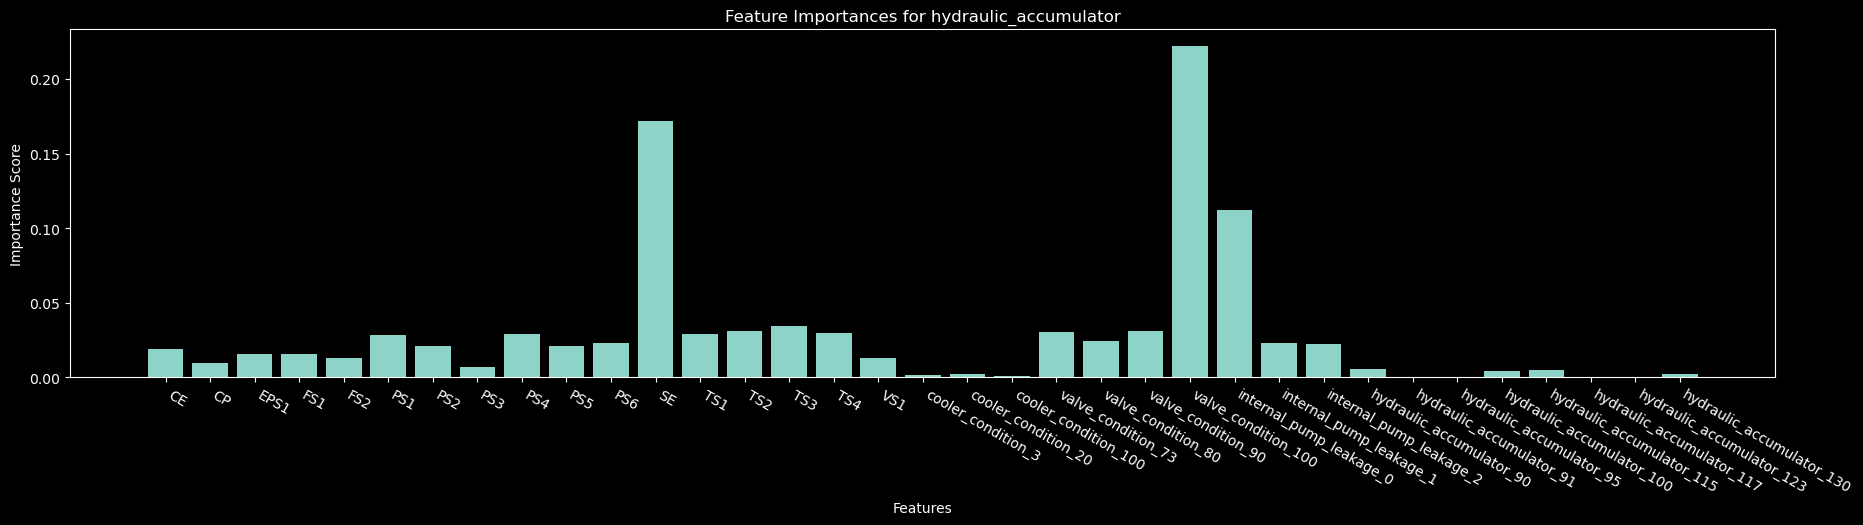

In [49]:
# Get feature names from the preprocessor
num_features = ['CE','CP','EPS1','FS1','FS2','PS1','PS2','PS3','PS4','PS5','PS6','SE','TS1','TS2','TS3','TS4', 'VS1']
cat_features = ['cooler_condition','valve_condition','internal_pump_leakage', 'hydraulic_accumulator']

# Numeric features remain the same
feature_names = num_features.copy()

# Get the feature importances from the trained model
important = stable_flag_model.named_steps['classifier'].feature_importances_

# For categorical features, we need to append the encoded feature names
ohe = stable_flag_model.named_steps['preprocessor'].named_transformers_['cat']
feature_names.extend(ohe.get_feature_names_out(cat_features))

# At this point, feature_names contains original numeric feature names and the transformed categorical feature names

# Now you can use this in your plot
fig, ax = plt.subplots(figsize=(22,6))
ax.bar(feature_names, important)
ax.set_xlabel('Features')
ax.set_ylabel('Importance Score')
ax.set_title(f"Feature Importances for {target}")
plt.xticks(rotation=-30, ha='left')
plt.subplots_adjust(bottom=0.3) 
plt.savefig('images/test_feature_importance.png', format='png')
plt.show()



# Area for Improvement - Hyperparameter Tuning: Valve Condition, etc
- reduced score by 10% reduced overfitting of the model to the training set using validation set

In [23]:
# Drop unnecessary columns from X_train and X_val
X = X_train.drop(columns=['Date','cooler_condition', 'valve_condition', 'internal_pump_leakage', 'hydraulic_accumulator', 'stable_flag'])
y = X_train['valve_condition']

X_val_transformed = X_val.drop(columns=['Date','cooler_condition', 'valve_condition', 'internal_pump_leakage', 'hydraulic_accumulator', 'stable_flag'])
y_val = X_val['valve_condition']

# Create an instance of SMOTE
sm = SMOTE(random_state=1)

# Create instances of your selected scaler and classifier
quant = QuantileTransformer(output_distribution='normal', random_state=1)
classifier = RandomForestClassifier(random_state=1)  

# Create a pipeline with SMOTE, scaler, and classifier
pipeline = ImbPipeline([('smote', sm), ('scaler', quant), ('classifier', classifier)])

# Fit the pipeline on the training set
pipeline.fit(X, y)

# Transform X_val using the scaler
X_val_transformed = pipeline.named_steps['scaler'].transform(X_val_transformed)

# Use the pipeline to make predictions on the validation set
y_val_pred = pipeline.named_steps['classifier'].predict(X_val_transformed)

# Compute precision, recall, and F1 score
classification_rep = classification_report(y_val, y_val_pred)
print("Classification Report:\n", classification_rep)

# Define the parameter grid
param_grid = {
    'classifier__n_estimators': [100, 200, 300, 500],
    'classifier__max_depth': [None, 5, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['auto', 'sqrt', 'log2'],
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__class_weight': [None, 'balanced', 'balanced_subsample']
}

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, scoring='precision_weighted', verbose=1, n_iter=10, cv=5)

# Fit the random search to the training data
random_search.fit(X, y)

# Print the best parameters
print("Best parameters: ", random_search.best_params_)


Classification Report:
               precision    recall  f1-score   support

          73       0.54      0.67      0.60        67
          80       0.37      0.37      0.37        62
          90       0.39      0.57      0.46        69
         100       0.95      0.76      0.85       243

    accuracy                           0.66       441
   macro avg       0.56      0.59      0.57       441
weighted avg       0.72      0.66      0.68       441

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters:  {'classifier__n_estimators': 500, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 2, 'classifier__max_features': 'log2', 'classifier__max_depth': 10, 'classifier__criterion': 'entropy', 'classifier__class_weight': None}


In [24]:
# Use the best model to make predictions on X_val
best_model = random_search.best_estimator_
y_val_pred = best_model.predict(X_val_transformed)

# Compute precision, recall, and F1 score
classification_rep = classification_report(y_val, y_val_pred)
print("Classification Report:\n", classification_rep)

Classification Report:
               precision    recall  f1-score   support

          73       0.00      0.00      0.00        67
          80       0.00      0.00      0.00        62
          90       0.00      0.00      0.00        69
         100       0.55      1.00      0.71       243

    accuracy                           0.55       441
   macro avg       0.14      0.25      0.18       441
weighted avg       0.30      0.55      0.39       441



C:\Users\sduckers\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
C:\Users\sduckers\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sduckers\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sduckers\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in lab

# Area for Improvement - PCA for redundant features?
- Since some sensor readings are highly correlated, they might cause multicollinearity. This could destabilize your model and make the effects of individual features difficult to separate if I am using linear models.I want to remove these redundant features, or combine them using techniques like Principal Component Analysis (PCA).

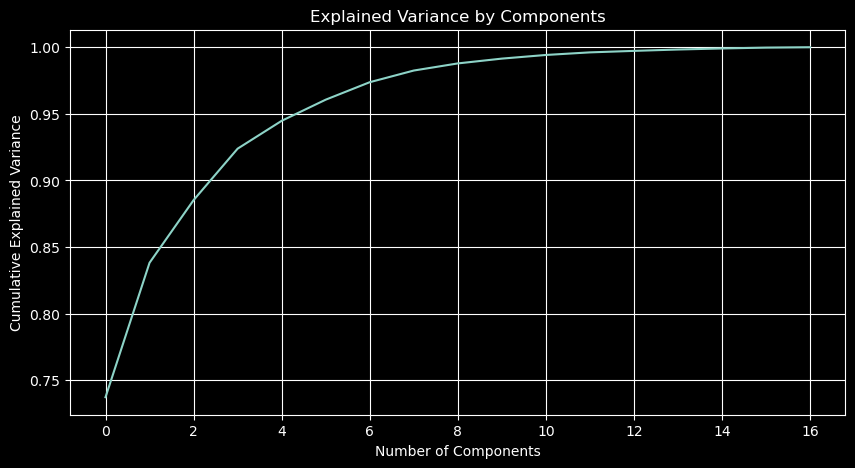

In [26]:
X = avery_df.drop(columns=['Date','cooler_condition', 'valve_condition', 'internal_pump_leakage', 'hydraulic_accumulator', 'stable_flag'])

# Initialize the transformer
quant = QuantileTransformer(output_distribution='normal')
# Transform the data
quant_data = quant.fit_transform(X)

# Perform PCA
pca = PCA().fit(quant_data)

# Plot the explained variances
plt.figure(figsize=(10,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance') 
plt.title('Explained Variance by Components')
plt.grid(True)
plt.show()

In [27]:
pca_data = PCA(n_components=2).fit_transform(quant_data)

# Get the first and second principal components
pca1 = pca_data[:, 0]
pca2 = pca_data[:, 1]

# Create a DataFrame combining PCA1, PCA2, and 'stable_flag'
combined_data = pd.concat([pd.Series(pca1, name='PCA1'), pd.Series(pca2, name='PCA2'), avery_df['stable_flag']], axis=1)
combined_data

PCA1      PCA2  stable_flag
0      2.969803 -5.322019            1
1      0.905511 -3.803645            1
2     -0.213499 -2.900347            1
3     -0.336783 -2.784382            1
4     -0.588835 -2.679325            1
...         ...       ...          ...
2200   8.274243 -0.700902            0
2201   8.429616 -0.432204            0
2202   9.009107 -0.717650            0
2203   9.036806 -0.609413            0
2204  10.010589 -1.802568            0

[2205 rows x 3 columns]

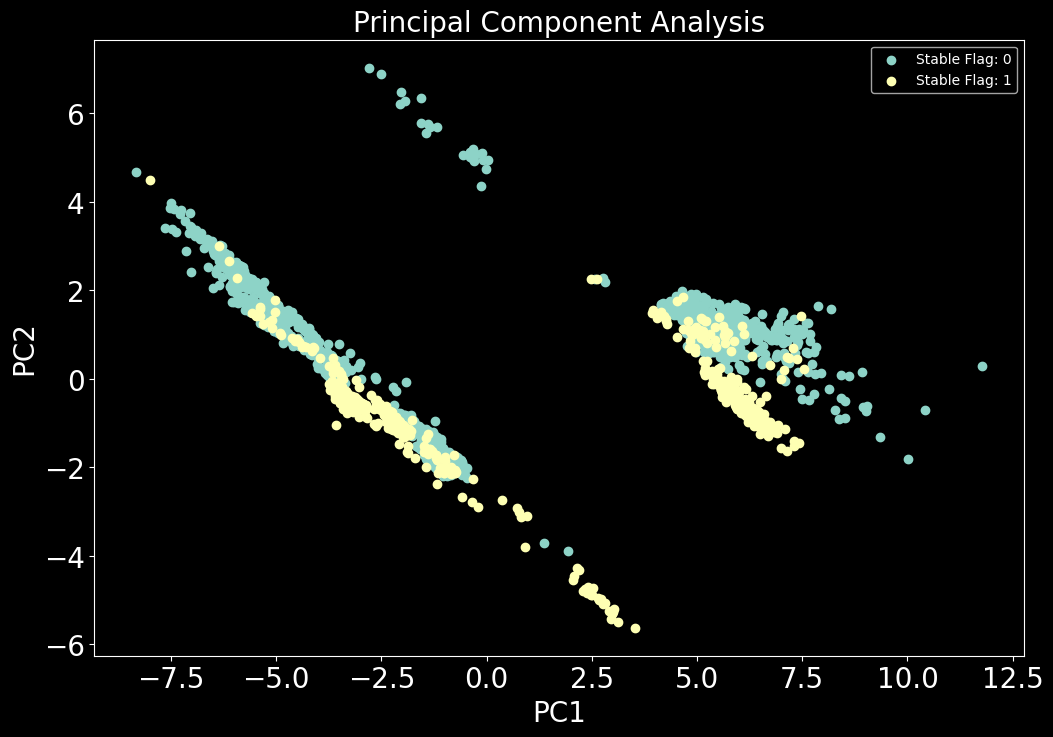

In [28]:
plt.figure(figsize=(12,8))


for class_value in [0, 1]:
    subset = combined_data[combined_data['stable_flag'] == class_value]
    plt.scatter(subset['PCA1'], subset['PCA2'], label=f'Stable Flag: {class_value}')

plt.title("Principal Component Analysis", size = 20)
plt.xlabel("PC1", size=20)
plt.xticks(fontsize=20)
plt.ylabel("PC2", size=20)
plt.yticks(fontsize=20)

plt.legend()
plt.show()
